In [2]:
import pandas as pd
import math

CITY_DATA_PROJECTED_COLUMNS = ['amenity', 'name', 'landuse', 'latitude', 'longitude', 'leisure', 'highway', 'natural', 'public_transport', 'railway', 'shop', 'tourism']
RADIUS = 1.5

def getDistanceFromLatLonInKm(lat1: float, lon1: float, lat2: float, lon2: float) -> float:
    def deg2rad(deg) -> float:
        return deg * (math.pi / 180)
    R = 6371 # Radius of the earth in km
    dLat = deg2rad(lat2-lat1)
    dLon = deg2rad(lon2-lon1)
    a = math.sin(dLat/2) * math.sin(dLat/2) + math.cos(deg2rad(lat1)) * math.cos(deg2rad(lat2)) * math.sin(dLon/2) * math.sin(dLon/2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    d = R * c # Distance in km
    return d

def computeNearest(row, column, df) -> float:
    lowest = math.inf
    df_masked = df[df[column]]
    for lat1, lon2 in zip(df_masked['latitude'], df_masked['longitude']):
        distance = getDistanceFromLatLonInKm(row['latitude'], row['longitude'], lat1, lon2)
        if distance < lowest:
            lowest = distance
    return lowest

def computeCountWithinRadius(row, column, df, radius) -> float:
    count = 0
    df_masked = df[df[column]]
    for lat1, lon2 in zip(df_masked['latitude'], df_masked['longitude']):
        distance = getDistanceFromLatLonInKm(row['latitude'], row['longitude'], lat1, lon2)
        if distance <= radius:
            count += 1
    return count

rentDf = pd.read_csv('rentfaster.csv')
rentDf = rentDf[rentDf['province'] == 'Alberta']

cityDf = pd.read_csv('osm_helper_data_Alberta/Alberta_Canada/Alberta_Canada_all_amenities.csv', usecols=CITY_DATA_PROJECTED_COLUMNS, low_memory=False)

cityDf['isSchool'] = cityDf['amenity'].isin(['university', 'school', 'college'])
cityDf['isRestaurant'] = cityDf['amenity'].isin(['restaurant', 'cafe', 'bar', 'cafe;fast_food', 'fast_food'])
cityDf['isCemetery'] = (cityDf['amenity'] == 'grave_yard') | (cityDf['landuse'] == 'cemetery')
cityDf['isPolice'] = cityDf['amenity'] == 'police'
cityDf['isHealthCare'] = cityDf['amenity'].isin(['dentist', 'clinic', 'doctors', 'pharmacy', 'hospital'])
cityDf['isCommunityCentre'] = cityDf['amenity'].isin(['social_centre', 'social_facility', 'community_centre'])
cityDf['isPlaceOfWorship'] = cityDf['amenity'] == 'place_of_worship'
cityDf['isLeisure'] = cityDf['leisure'].notna()
cityDf['isPublicTransport'] = cityDf['public_transport'].notna() | cityDf['railway'] | cityDf['highway'].isin(['bus_stop', 'bus_stop;street_lamp', 'platform'])
cityDf['isShop'] = cityDf['shop'].notna()
cityDf['isTourism'] = cityDf['tourism'].notna()

cityDf.drop_duplicates(subset=['longitude', 'latitude', 'name', 'isSchool', 'isRestaurant', 'isCemetery', 'isPolice', 'isHealthCare', 'isCommunityCentre', 'isPlaceOfWorship', 'isLeisure', 'isPublicTransport', 'isShop', 'isTourism'], inplace=True)

# filter out rows that do not fall into any categories
cityDf = cityDf[(cityDf['isSchool'] == True) | (cityDf['isRestaurant'] == True) | (cityDf['isCemetery'] == True) | (cityDf['isPolice'] == True) | (cityDf['isHealthCare'] == True) | (cityDf['isCommunityCentre'] == True) | (cityDf['isPlaceOfWorship'] == True) | (cityDf['isLeisure'] == True) | (cityDf['isPublicTransport'] == True) | (cityDf['isShop'] == True) | (cityDf['isTourism'] == True)]
cityDf = cityDf.drop(columns=['amenity', 'name', 'leisure', 'highway', 'natural', 'public_transport', 'railway', 'shop', 'tourism'])

# Derive additional features
rentDf["nearestSchool"] = rentDf.apply(lambda r: computeNearest(r, "isSchool", cityDf), axis=1)
rentDf['nearestPolice'] = rentDf.apply(lambda r: computeNearest(r, "isPolice", cityDf), axis=1)
rentDf['restaurantCount'] = rentDf.apply(lambda r: computeCountWithinRadius(r, "isRestaurant", cityDf, RADIUS), axis=1)
rentDf['cemeteryCount'] = rentDf.apply(lambda r: computeCountWithinRadius(r, "isCemetery", cityDf, RADIUS), axis=1)
rentDf['healthCareCount'] = rentDf.apply(lambda r: computeCountWithinRadius(r, "isHealthCare", cityDf, RADIUS), axis=1)
rentDf['communityCentreCount'] = rentDf.apply(lambda r: computeCountWithinRadius(r, "isCommunityCentre", cityDf, RADIUS), axis=1)
rentDf['placeOfWorshipCount'] = rentDf.apply(lambda r: computeCountWithinRadius(r, "isPlaceOfWorship", cityDf, RADIUS), axis=1)
rentDf['leisureCount'] = rentDf.apply(lambda r: computeCountWithinRadius(r, "isLeisure", cityDf, RADIUS), axis=1)
rentDf['shopCount'] = rentDf.apply(lambda r: computeCountWithinRadius(r, "isShop", cityDf, RADIUS), axis=1)
rentDf['tourismCount'] = rentDf.apply(lambda r: computeCountWithinRadius(r, "isTourism", cityDf, RADIUS), axis=1)

rentDf.to_csv("datasets/dataset_joined.csv", index=False)

In [3]:
import pandas as pd

IRRELEVANT_COLUMNS = ['rentfaster_id', 'address', 'link', 'availability_date', 'province', 'city']
LIVING_SPACE_TYPES = ['Apartment', 'Condo Unit', 'Basement', 'House', 'Townhouse', 'Main Floor', 'Room For Rent', 'Duplex', 'Loft', 'Mobile', 'Vacation Home']
RENT_PRICE_THRESHOLD = 2000

df = pd.read_csv('datasets/dataset_joined.csv')

df = df.drop_duplicates()
df = df.drop(columns=IRRELEVANT_COLUMNS)
df = df[df['type'].isin(LIVING_SPACE_TYPES)] # filter out non-living spaces

# feature extraction
df['beds'] = df['beds'].replace('Studio', '0')
df['beds'] = df['beds'].str.extract(r'(\d+)') # extract bed count from string

df['baths'] = df['baths'].replace('none', 0)

df['sq_feet'] = df['sq_feet'].str.replace(',', '')
df['sq_feet'] = df['sq_feet'].str.extract(r'(\d+)') # extract square footage from string

# remove rows with missing data, since we have a lot of data points
df = df.dropna()

df['beds'] = df['beds'].astype(int)
df['baths'] = df['baths'].astype(float)
df['cats'] = df['cats'].astype(int)
df['dogs'] = df['dogs'].astype(int)
df['sq_feet'] = df['sq_feet'].astype(int)
df['price'] = df['price'].astype(float)

# one-hot encoding on categorical columns
categorical_columns = ['lease_term', 'furnishing', 'type', 'smoking']
for column in categorical_columns:
    one_hot = pd.get_dummies(df[column], prefix=column, dtype=int)
    df = df.join(one_hot)
df = df.drop(columns=categorical_columns)

# z-score standardization on numerical values
numerical_columns = ['latitude', 'longitude', 'beds', 'baths', 'sq_feet', 'nearestSchool', 'nearestPolice', 'restaurantCount', 'cemeteryCount', 'healthCareCount', 'communityCentreCount', 'placeOfWorshipCount', 'leisureCount', 'shopCount', 'tourismCount']
for column in numerical_columns:
    if df[column].std() == 0:
        continue
    df['{}_standardized'.format(column)] = (df[column] - df[column].mean()) / df[column].std()

# convert target variable into class
df['price'] = df['price'] >= RENT_PRICE_THRESHOLD
df['price'] = df['price'].replace({ True: ">=2000", False: "<2000" })

df.to_csv('datasets/dataset_cleaned.csv', index=False)

In [4]:
import sys
import os
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from pathlib import Path
from pandas.plotting import scatter_matrix

joined = pd.read_csv("datasets/dataset_joined.csv")
cleaned = pd.read_csv("datasets/dataset_cleaned.csv")

%matplotlib inline

In [5]:
print("(# of Rows, # of Columns for Cleaned Data):", cleaned.shape) 
print("(# of Rows, # of Columns for Joined Data):", joined.shape) 
print("\nCleaned Data Types:\n", cleaned.dtypes) # types: object, float64, int64
print("\nJoined Data Types:\n", joined.dtypes)

display(joined.head(3))
display(cleaned.head(3))

(# of Rows, # of Columns for Cleaned Data): (6591, 57)
(# of Rows, # of Columns for Joined Data): (13777, 28)

Cleaned Data Types:
 latitude                              float64
longitude                             float64
price                                  object
beds                                    int64
baths                                 float64
sq_feet                                 int64
cats                                    int64
dogs                                    int64
nearestSchool                         float64
nearestPolice                         float64
restaurantCount                         int64
cemeteryCount                           int64
healthCareCount                         int64
communityCentreCount                    int64
placeOfWorshipCount                     int64
leisureCount                            int64
shopCount                               int64
tourismCount                            int64
lease_term_12 months                    

,rentfaster_id,city,province,address,latitude,longitude,lease_term,type,price,beds,...,nearestSchool,nearestPolice,restaurantCount,cemeteryCount,healthCareCount,communityCentreCount,placeOfWorshipCount,leisureCount,shopCount,tourismCount
0,468622,Airdrie,Alberta,69 Gateway Dr NE,51.305962,-114.012515,Long Term,Townhouse,2495.0,2 Beds,...,0.333439,16.725785,2,0,1,0,0,5,0,0
1,468622,Airdrie,Alberta,69 Gateway Dr NE,51.305962,-114.012515,Long Term,Townhouse,2695.0,3 Beds,...,0.333439,16.725785,2,0,1,0,0,5,0,0
2,468622,Airdrie,Alberta,69 Gateway Dr NE,51.305962,-114.012515,Long Term,Townhouse,2295.0,2 Beds,...,0.333439,16.725785,2,0,1,0,0,5,0,0


,latitude,longitude,price,beds,baths,sq_feet,cats,dogs,nearestSchool,nearestPolice,...,sq_feet_standardized,nearestSchool_standardized,nearestPolice_standardized,restaurantCount_standardized,cemeteryCount_standardized,healthCareCount_standardized,placeOfWorshipCount_standardized,leisureCount_standardized,shopCount_standardized,tourismCount_standardized
0,51.305962,-114.012515,>=2000,2,2.5,1403,1,1,0.333439,16.725785,...,0.695746,-0.69548,0.504273,-0.675212,-0.012318,-0.966382,-0.739647,-0.086843,-0.750203,-0.567558
1,51.305962,-114.012515,>=2000,3,2.5,1496,1,1,0.333439,16.725785,...,0.860128,-0.69548,0.504273,-0.675212,-0.012318,-0.966382,-0.739647,-0.086843,-0.750203,-0.567558
2,51.305962,-114.012515,>=2000,2,2.5,1180,1,1,0.333439,16.725785,...,0.301584,-0.69548,0.504273,-0.675212,-0.012318,-0.966382,-0.739647,-0.086843,-0.750203,-0.567558


Price class counts (cleaned):


price
<2000     3603
>=2000    2988
Name: count, dtype: int64

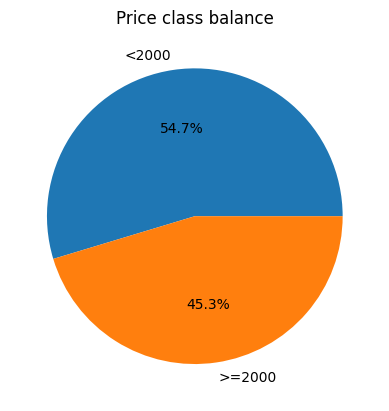

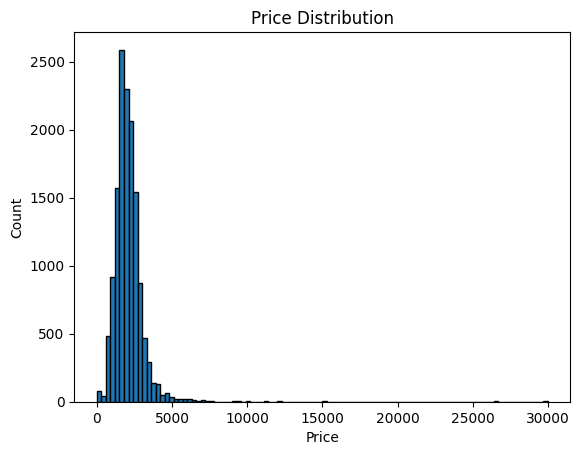

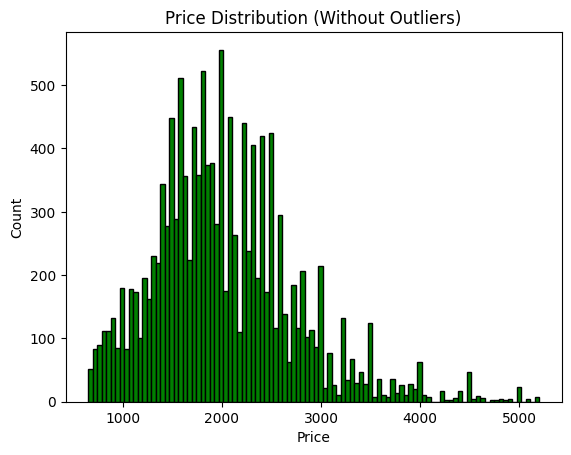

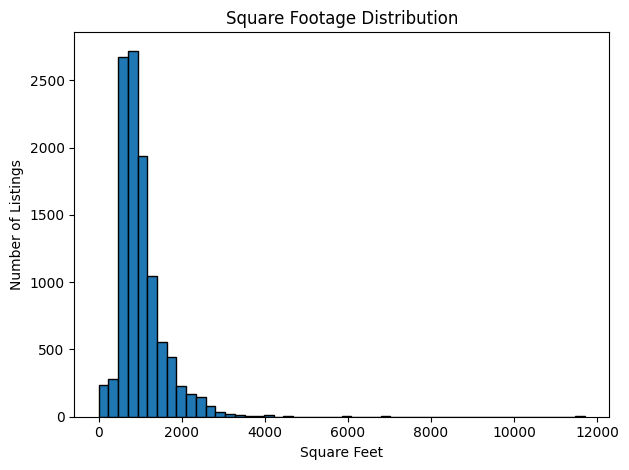

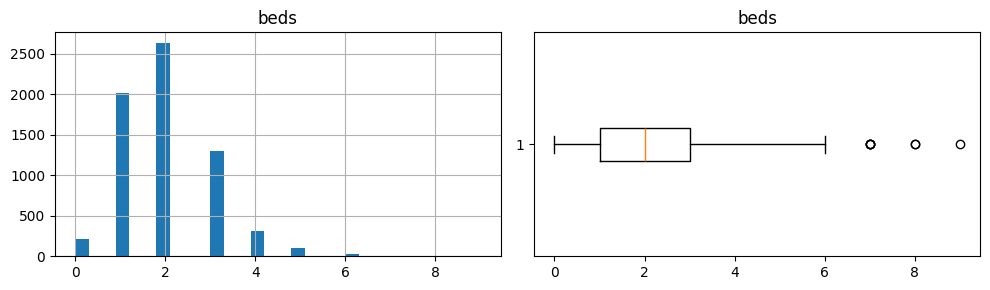

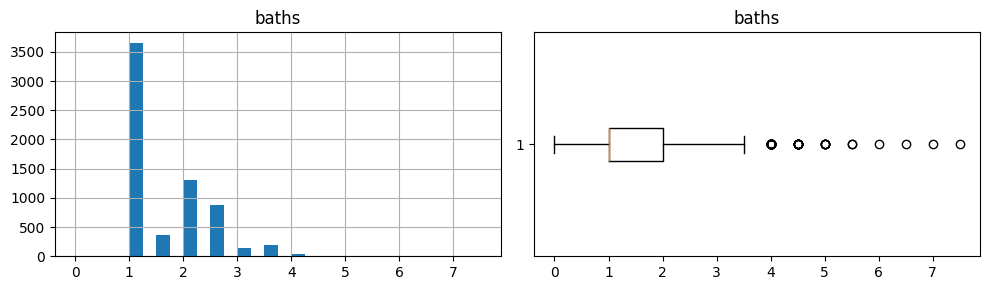

In [31]:
print("Price class counts (cleaned):")
joined['price'] = pd.to_numeric(joined['price'], errors='coerce')
display(cleaned["price"].value_counts())
cleaned["price"].value_counts().plot.pie(autopct="%1.1f%%", ylabel="", title="Price class balance")
plt.show()

plt.hist(joined["price"].dropna(), bins=100, edgecolor="black")
plt.title("Price Distribution")
plt.xlabel("Price")
plt.ylabel("Count")
plt.show()

low, high = np.percentile(joined["price"], [1, 99])
price_clean = joined["price"][(joined["price"] >= low) & (joined["price"] <= high)]

# histogram without outliers
plt.hist(price_clean, bins=100, color="green", edgecolor="black")
plt.title("Price Distribution (Without Outliers)")
plt.xlabel("Price")
plt.ylabel("Count")
plt.show()

plt.hist(joined["sq_feet"].dropna(), bins=50, edgecolor="black")
plt.title("Square Footage Distribution")
plt.xlabel("Square Feet")
plt.ylabel("Number of Listings")
plt.tight_layout()
plt.show()

num_cols = ['beds','baths']
for c in num_cols:
    fig, axs = plt.subplots(1,2, figsize=(10,3))
    cleaned[c].hist(ax=axs[0], bins=30)
    axs[0].set_title(f"{c}")
    axs[1].boxplot(cleaned[c].dropna(), vert=False)
    axs[1].set_title(f"{c}")
    plt.tight_layout()
    plt.show()

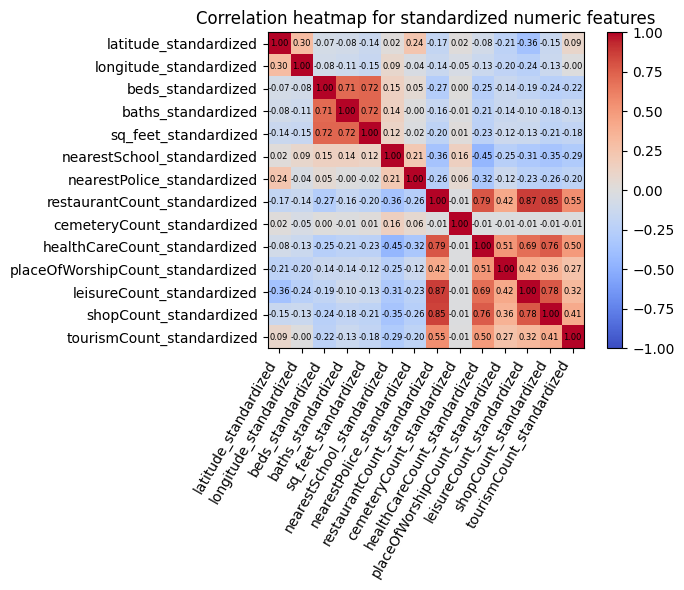

Pairs with |corr| >= 0.60:
beds_standardized and baths_standardized : 0.705
beds_standardized and sq_feet_standardized : 0.719
baths_standardized and sq_feet_standardized : 0.724
restaurantCount_standardized and healthCareCount_standardized : 0.788
restaurantCount_standardized and leisureCount_standardized : 0.872
restaurantCount_standardized and shopCount_standardized : 0.852
healthCareCount_standardized and leisureCount_standardized : 0.691
healthCareCount_standardized and shopCount_standardized : 0.759
leisureCount_standardized and shopCount_standardized : 0.781


In [7]:
std_cols = [c for c in cleaned.columns if c.endswith("_standardized")]
corr = cleaned[std_cols].corr()

fig, ax = plt.subplots(figsize=(8,6))
heatmap = ax.imshow(corr.values, vmin=-1, vmax=1, cmap= "coolwarm")
ax.set_xticks(range(len(std_cols))); ax.set_xticklabels(std_cols, rotation=60, ha="right")
ax.set_yticks(range(len(std_cols))); ax.set_yticklabels(std_cols)

for i in range(len(std_cols)):
    for j in range(len(std_cols)):
        ax.text(j, i, f"{corr.iloc[i,j]:.2f}", ha="center", va="center", fontsize=6)
fig.colorbar(heatmap, ax=ax, fraction=0.046, pad=0.04)
plt.title("Correlation heatmap for standardized numeric features")
plt.tight_layout()
plt.show()

# list high correlation pairs based on set thershold
threshold = 0.6
pairs = []
for i in range(len(std_cols)):
    for j in range(i+1, len(std_cols)):
        v = corr.iloc[i,j]
        if abs(v) >= threshold:
            pairs.append((std_cols[i], std_cols[j], v))
print("Pairs with |corr| >= {:.2f}:".format(threshold))
for p in pairs:
    print(p[0], "and", p[1], ":", round(p[2],3))

Type counts:


type_Apartment        2747
type_Condo Unit       1016
type_House             705
type_Townhouse         672
type_Basement          636
type_Main Floor        364
type_Duplex            234
type_Room For Rent     202
type_Loft               12
type_Vacation Home       2
type_Mobile              1
dtype: int64

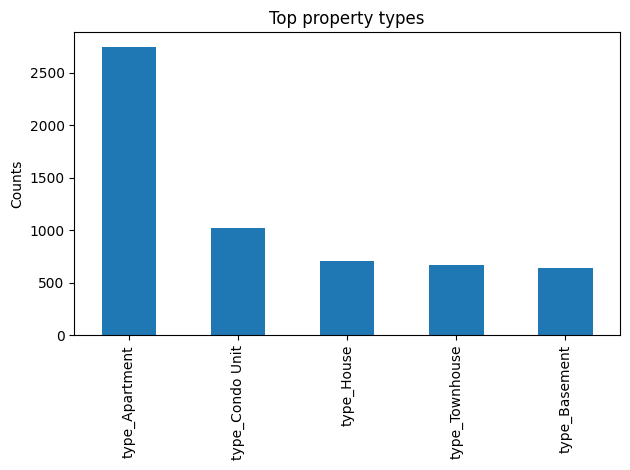

Furnishing counts:


furnishing_Furnished                   750
furnishing_Negotiable                  178
furnishing_Unfurnished                5660
furnishing_Unfurnished, Negotiable       3
dtype: int64

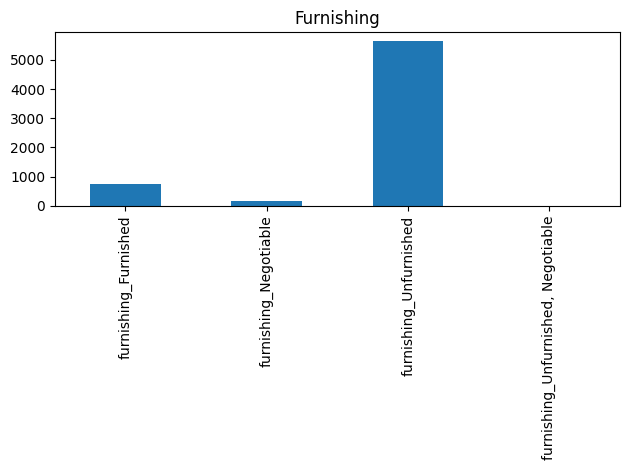

Lease term counts:


lease_term_Long Term     5781
lease_term_Negotiable     631
lease_term_Short Term     123
lease_term_12 months       54
lease_term_6 months         1
lease_term_months           1
dtype: int64

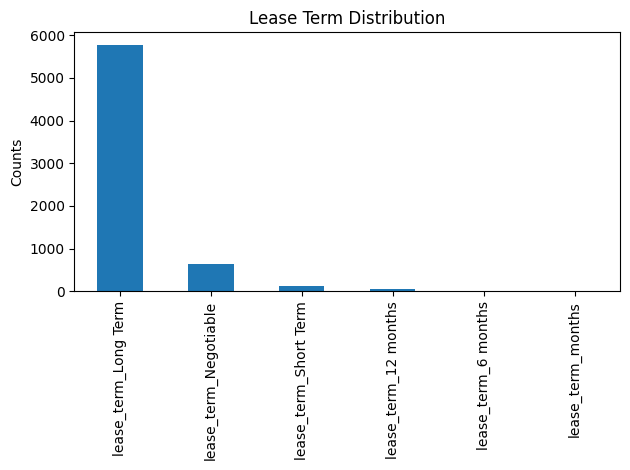

In [8]:
type_cols = [c for c in cleaned.columns if c.startswith("type_")]
type_counts = cleaned[type_cols].sum().sort_values(ascending=False)
print("Type counts:")
display(type_counts)
type_counts.head().plot.bar()
plt.title("Top property types")
plt.ylabel("Counts")
plt.tight_layout()
plt.show()

furn_cols = [c for c in cleaned.columns if c.startswith("furnishing_")]
furn_counts = cleaned[furn_cols].sum()
print("Furnishing counts:")
display(furn_counts)
furn_counts.plot.bar()
plt.title("Furnishing")
plt.tight_layout()
plt.show()

lease_cols = [c for c in cleaned.columns if c.startswith("lease_term_")]
lease_counts = cleaned[lease_cols].sum().sort_values(ascending=False)
print("Lease term counts:")
display(lease_counts)
lease_counts.plot.bar()
plt.title("Lease Term Distribution")
plt.ylabel("Counts")
plt.tight_layout()
plt.show()

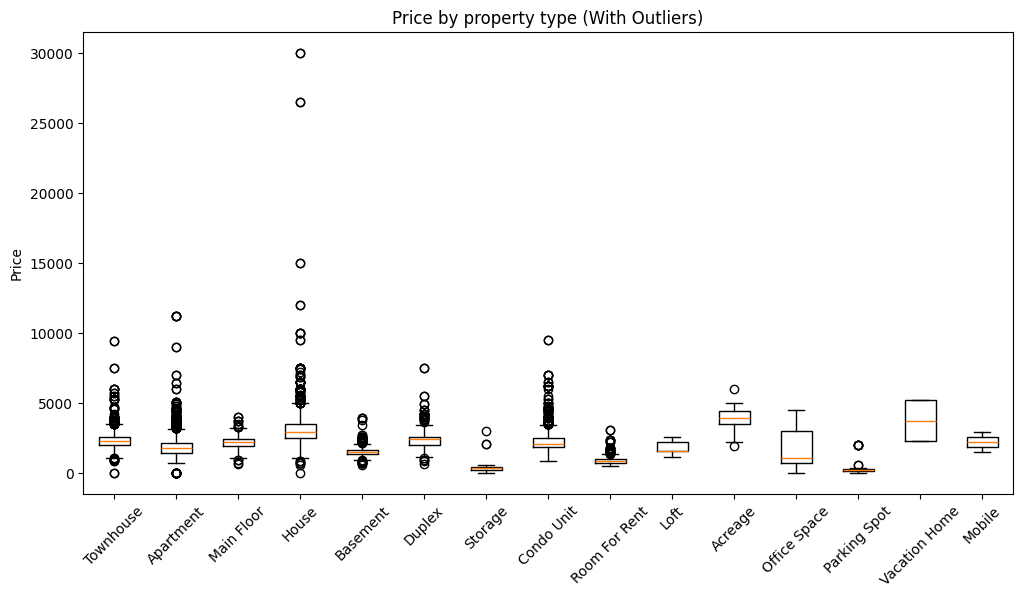

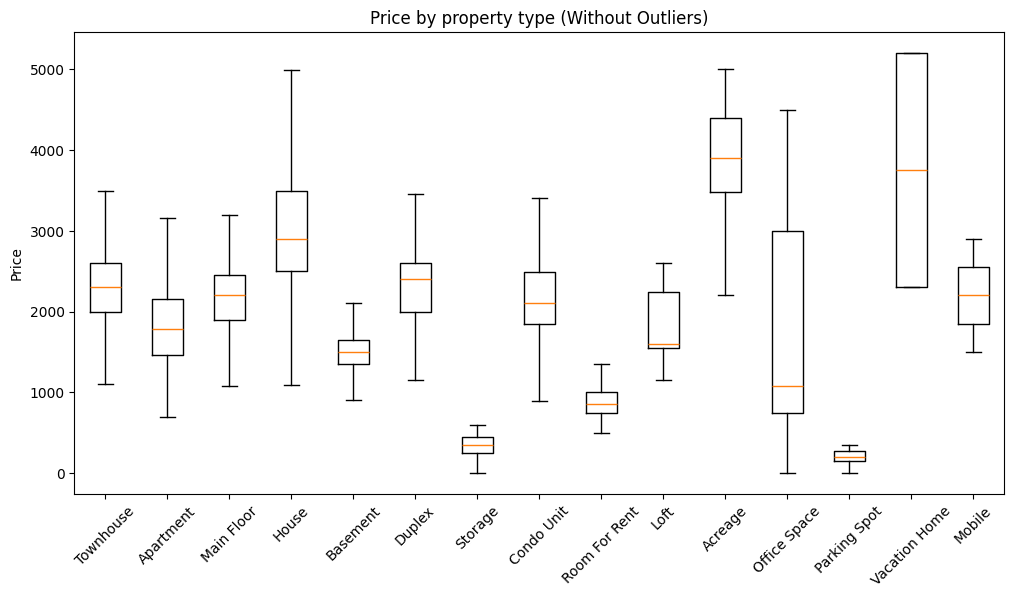

In [9]:
# boxplot to spot outliers and compare groups (price by property type)
property_types = joined["type"].dropna().unique().tolist()

# create a list of price arrays for each property type
data_for_box = [joined.loc[joined["type"] == t, "price"].dropna().values for t in property_types]

fig = plt.figure(figsize=(12,6))
plt.boxplot(data_for_box, tick_labels=property_types, showfliers=True, vert=True)
plt.title("Price by property type (With Outliers)")
plt.ylabel("Price")
plt.xticks(rotation=45)
plt.show()

fig = plt.figure(figsize=(12,6))
plt.boxplot(data_for_box, tick_labels=property_types, showfliers=False, vert=True)
plt.title("Price by property type (Without Outliers)")
plt.ylabel("Price")
plt.xticks(rotation=45)
plt.show()

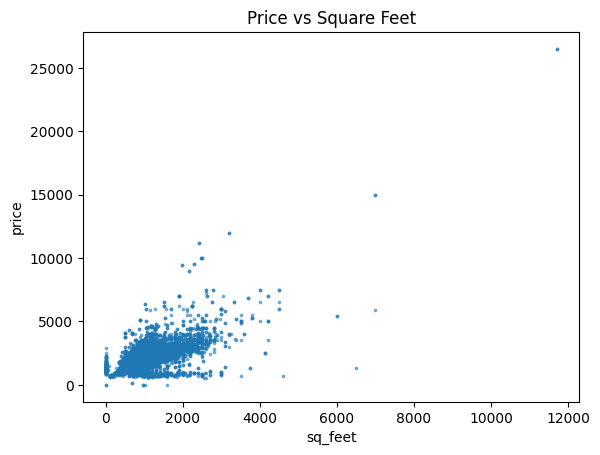

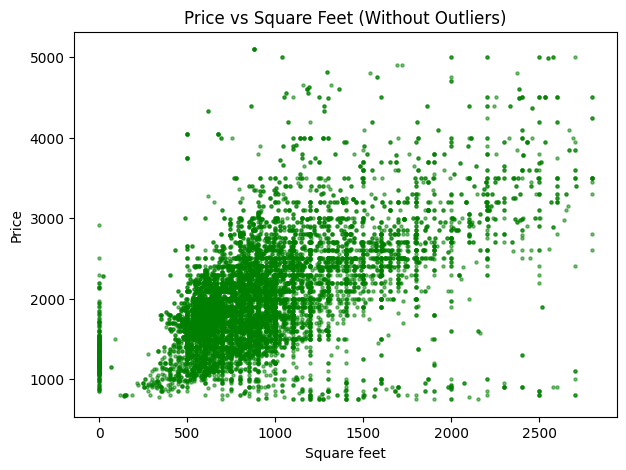

In [10]:
# ensure all our numeric first
joined["sq_feet"] = pd.to_numeric(joined["sq_feet"], errors="coerce")
joined["price"] = pd.to_numeric(joined["price"], errors="coerce")

mask = joined["price"].notnull() & joined["sq_feet"].notnull()

plt.scatter(joined.loc[mask, "sq_feet"], joined.loc[mask, "price"], s=3, alpha=0.5)
plt.xlabel("sq_feet")
plt.ylabel("price")
plt.title("Price vs Square Feet")


x = joined.loc[mask, "sq_feet"].values
y = joined.loc[mask, "price"].values
plt.show()

x_low, x_high = np.percentile(x, [1, 99])
y_low, y_high = np.percentile(y, [1, 99])

mask_no_outliers = (x >= x_low) & (x <= x_high) & (y >= y_low) & (y <= y_high)
x2 = x[mask_no_outliers]
y2 = y[mask_no_outliers]

plt.figure(figsize=(7,5))
plt.scatter(x2, y2, s=5, alpha=0.5, color="green")
plt.xlabel("Square feet")
plt.ylabel("Price")
plt.title("Price vs Square Feet (Without Outliers)")
plt.show()

In [11]:
q1 = joined["price"].quantile(0.25)
q3 = joined["price"].quantile(0.75)
iqr = q3 - q1
lower = q1 - 1.5 * iqr
upper = q3 + 1.5 * iqr
outliers = joined[(joined["price"] < lower) | (joined["price"] > upper)]
print("IQR outlier thresholds:", lower, upper)
print("Outlier count:", len(outliers), "out of", len(joined), f"({len(outliers)/len(joined):.2%})")
display(outliers.sort_values("price", ascending=False).head(10))

IQR outlier thresholds: 217.5 3709.5
Outlier count: 539 out of 13777 (3.91%)


,rentfaster_id,city,province,address,latitude,longitude,lease_term,type,price,beds,...,nearestSchool,nearestPolice,restaurantCount,cemeteryCount,healthCareCount,communityCentreCount,placeOfWorshipCount,leisureCount,shopCount,tourismCount
4586,571693,Calgary,Alberta,13 Ave NE,51.064172,-114.049670,Short Term,House,29990.0,3 Beds,...,2.751645,2.376172,58,0,12,0,1,4,5,4
13244,571693,Calgary,Alberta,13 Ave NE,51.064172,-114.049670,Short Term,House,29990.0,3 Beds,...,2.751645,2.376172,58,0,12,0,1,4,5,4
2291,490755,Calgary,Alberta,Springbank Hill,51.028096,-114.195080,Negotiable,House,26500.0,8 Beds,...,4.190954,9.171806,11,0,0,0,0,1,0,0
10939,490755,Calgary,Alberta,Springbank Hill,51.028096,-114.195080,Negotiable,House,26500.0,8 Beds,...,4.190954,9.171806,11,0,0,0,0,1,0,0
11101,535326,Calgary,Alberta,79 Bel-Aire Place SW,50.998793,-114.093004,12 months,House,14995.0,3 Beds,...,2.269509,1.400589,43,0,11,0,0,4,16,0
2460,535326,Calgary,Alberta,79 Bel-Aire Place SW,50.998793,-114.093004,12 months,House,14995.0,3 Beds,...,2.269509,1.400589,43,0,11,0,0,4,16,0
1328,440585,Calgary,Alberta,1209 Riverdale Avenue Southwest,51.016810,-114.088027,Negotiable,House,12000.0,4 Beds,...,2.014831,2.390567,22,0,2,0,3,9,5,0
9987,440585,Calgary,Alberta,1209 Riverdale Avenue Southwest,51.016810,-114.088027,Negotiable,House,12000.0,4 Beds,...,2.014831,2.390567,22,0,2,0,3,9,5,0
8870,483743,Calgary,Alberta,524 10th Ave,51.043668,-114.072088,Long Term,Apartment,11200.0,2 Beds,...,0.770906,0.428378,417,0,29,0,2,22,54,10
675,532711,Calgary,Alberta,524 10 Avenue SW,51.043700,-114.072120,Long Term,Apartment,11200.0,2 Beds,...,0.769520,0.428302,418,0,29,0,2,22,54,10


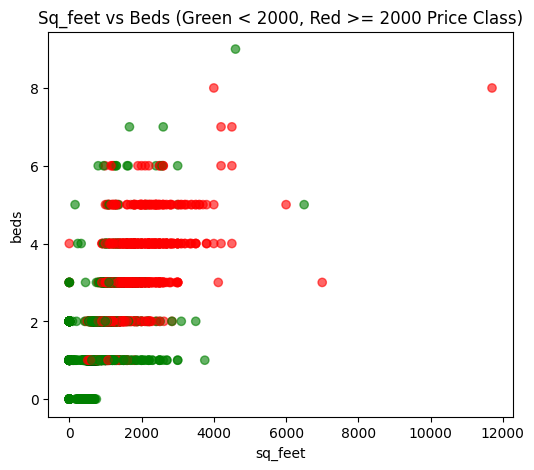

In [12]:
fig, ax = plt.subplots(figsize=(6,5))
colors = cleaned['price'].map({'>=2000':'red','<2000':'green'})
ax.scatter(cleaned['sq_feet'], cleaned['beds'], c=colors, alpha=0.6)
ax.set_xlabel('sq_feet'); ax.set_ylabel('beds')
ax.set_title('Sq_feet vs Beds (Green < 2000, Red >= 2000 Price Class)')
plt.show()

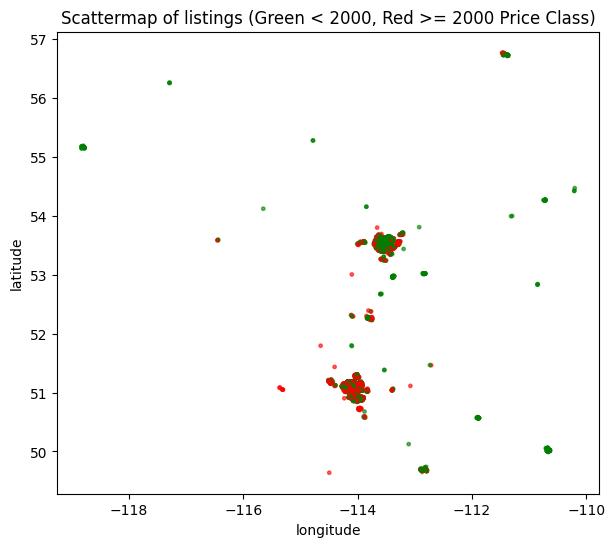

In [13]:
plt.figure(figsize=(7,6))
classes = {'>=2000':'red','<2000':'green'}
plt.scatter(cleaned['longitude'], cleaned['latitude'], c=cleaned['price'].map(classes), s=6, alpha=0.6)
plt.xlabel("longitude"); plt.ylabel("latitude")
plt.title("Scattermap of listings (Green < 2000, Red >= 2000 Price Class)")
plt.show()

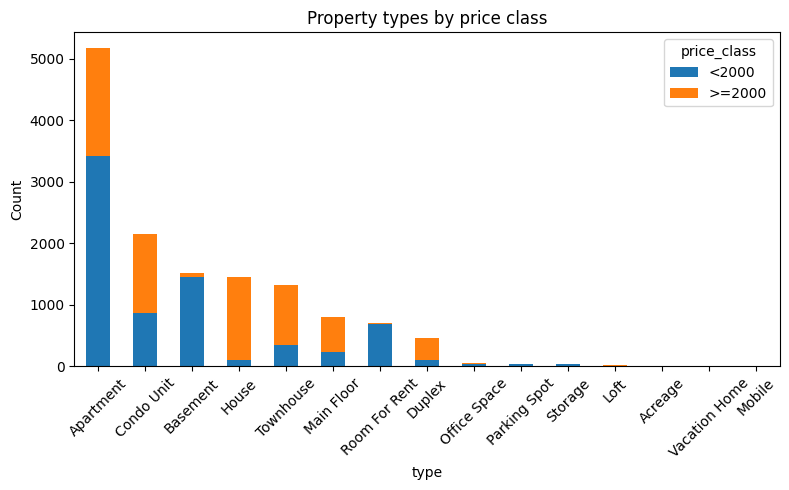

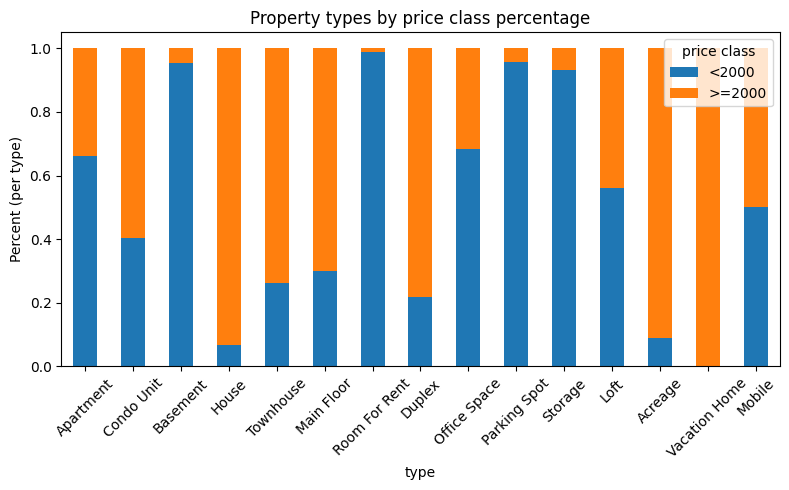

In [14]:
joined['price_class'] = pd.cut(joined['price'], bins=[-1,1999,1e9], labels=['<2000','>=2000'])
ct = pd.crosstab(joined['type'], joined['price_class'])
ct_pct = ct.div(ct.sum(axis=1), axis=0) 

property_types = ct.sum(axis=1).sort_values(ascending=False).index.tolist()
ct.loc[property_types].plot(kind='bar', stacked=True, figsize=(8,5))
plt.ylabel("Count")
plt.title("Property types by price class")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# show percent version too
ct_pct.loc[property_types].plot(kind='bar', stacked=True, figsize=(8,5))
plt.ylabel("Percent (per type)")
plt.title("Property types by price class percentage")
plt.legend(title='price class')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

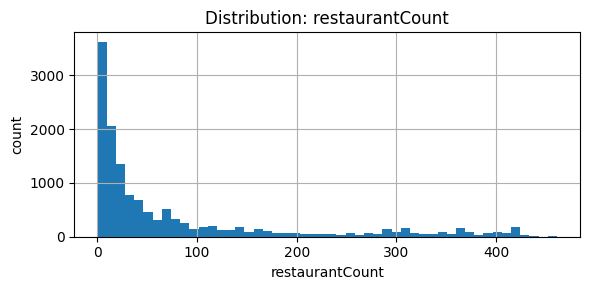

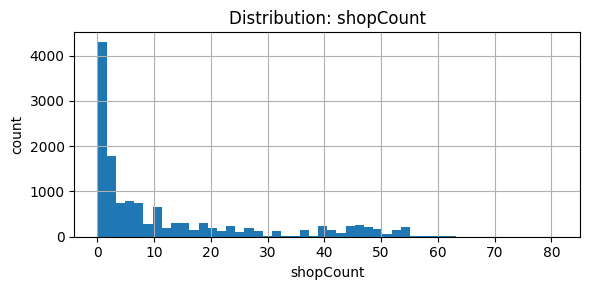

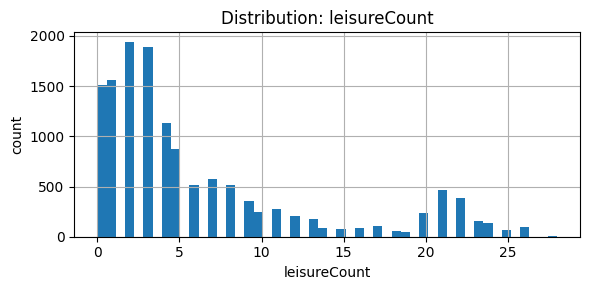

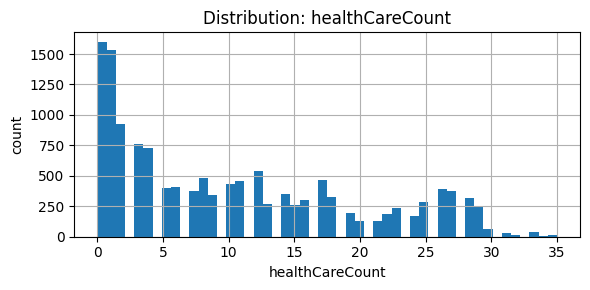

In [15]:
# highly correlated ones
amen_cols = ['restaurantCount','shopCount','leisureCount','healthCareCount']
for c in amen_cols:
    plt.figure(figsize=(6,3))
    joined[c].hist(bins=50)
    plt.title(f"Distribution: {c}")
    plt.xlabel(c); plt.ylabel("count")
    plt.tight_layout()
    plt.show()

Loaded two datasets: dataset_joined.csv, the joined RentFaster and OSM-derived amenity features, and dataset_cleaned.csv, which is cleaned, encoded, and standardized version used for modeling. The cleaned set contains numeric features (ie. beds, baths, sq_feet, nearest amenity distances, and amenity counts) and one-hot encoded categorical features (type, furnishing, lease terms). 

The binary target was created at a threshold of $2,000: cleaned data shows 3,603 listings <2000 (54.7%) and 2,988 listings >=2000 (45.3%), showing a reasonably normal balance.

Using the IQR method, roughly 4% (539) price outliers wre found, which is reasonable but should still be looked at in the future. Boxplots also reveal outliers that may either reflect real, rare listings or data errors, that require further analysis and considieration in future stages.

The correlation heatmap shows the strongest linear relationships among certain standardized numeric features (ie. sq_feet and beds, restaurantCount and shopCount, etc.) These pairs are often positively correlated because denser commercial areas tend to have more amenity types, and that larger housing units will naturally have more beds and baths. Amenity counts are also strongly correlated with eachother, which is again reasonable due to the natural urban layouts of cities. 

Scatter maps of latitude/longitude colored by price classes show geographic clustering of priced listings, which are useful indicators of urban and suburban areas. These can be looked into further in later stages as well.